In [1]:
!pip install gradio
!pip install keybert

In [2]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
# os.environ["CUDA_VISIBLE_DEVICES"]=""

In [3]:
# Imports
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
import numpy as np
import PIL
from PIL import Image
import gradio as gr
import sys
import openai
sys.path.append("../")
import speech_recognition as sr
import pygame
from pygame import mixer
import cv2
from vosk import Model, KaldiRecognizer, SetLogLevel
from pydub import AudioSegment
import wave
import json
from Talking_Head.Talking_Head import Talking_Head
from putting_it_together import blink_loop
%matplotlib inline
import torch
from PIL import Image
import matplotlib.pyplot as plt
import multiprocess
import gradio as gr
import time
import numpy as np
from copy import deepcopy
import asyncio
import threading
import pygame
from pygame import mixer

pygame 2.1.2 (SDL 2.0.18, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
from putting_it_together import WaifuObj

In [5]:
# Audio recognizer
r = sr.Recognizer()

In [6]:
# Path to the custom audio model
audio_model_path = "../Audio_Generation/Generation_Scripts/saved_models/default"

# Path to the custom audio data
audio_data_path = "../Audio_Generation/Generation_Scripts/data/albedo"

# Path to the custom model to load in
custom_model_path = "../Finetuning/outputs/r/"

In [7]:
# The initial summary is initially a basic prompt telling GPT-3 who it is
initial_summ = "You are my female waifu girlfriend who loves me."\
# The initial prompt tells GPT-3 how to respond
initial_prompt = "Me: Hi\nYou: Hello\n\n"\
    "Me: How are you?\nYou: Good. How are you?\n\n"\
    "Me: I'm good.\nYou: Nice to meet you.\n\n"

In [8]:
# Setup function to setup the environment
# memory_file = "config_file.json"
memory_file = None
Module = WaifuObj(initial_summ, initial_prompt, False, audio_model_path, audio_data_path, custom_model_path, memory_file)

Initializing image model...


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Image model initialized!
Initializing custom text model
Custom text model initialized!
Not loading custom audio model


In [9]:
device = torch.device("cuda:0")

In [10]:
# Load in the image
# img = Image.open("test.png")
img = Image.open("../Talking_Head/data/illust/../../../test3.png")

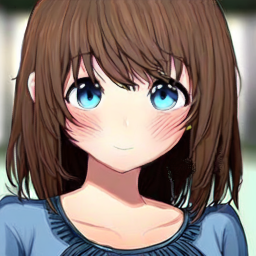

In [11]:
# Let's make a global Talking Head class to store the global vector
global img_anim
img_anim = Talking_Head(torch.device("cuda:0"), 0.5, automatic_EMA=True)

# Load in the new image
img_anim.load_new_image(img=deepcopy(img))

# Default pose for the image
img_anim.change_pose()

In [12]:
# Function to extract the word data from a mp3 file
def extract_word_data(filename):
    # Load in the model
    model_path = "../vosk_models/vosk-model-small-en-us-0.15"
    model = Model(model_path)
    
    # Make the audio a wav file
    f = AudioSegment.from_mp3("tmp.mp3")
    f.export("tmp.wav", format="wav")
    
    # Read in the audio
    with wave.open("tmp.wav", "rb") as wf:
        # Prepare the model for rekognition
        rec = KaldiRecognizer(model, wf.getframerate())
        rec.SetWords(True)

        # get the list of JSON dictionaries
        results = []
        # recognize speech using vosk model
        data = wf.readframes(wf.getnframes())
        while len(data) > 0:
            if rec.AcceptWaveform(data):
                part_result = json.loads(rec.Result())
                results.append(part_result)
            data = wf.readframes(wf.getnframes())
        part_result = json.loads(rec.FinalResult())
        results.append(part_result)
    
    audio_trans = results[0]["result"]
    
    # Get the delay between each word
    for i in range(1, len(audio_trans)):
        audio_trans[i]["delay"] = audio_trans[i]["start"]-audio_trans[i-1]["end"]
    audio_trans[0]["delay"] = audio_trans[0]["start"]
    
    return audio_trans

In [13]:
# Literally all this function does is update the
# eye part of the vector every so often
global DONE
DONE = False
async def blink_loop():
    global img_anim
    
    # We want to iterate forever
    while not DONE:
        # Wait a little to blink again
        if img_anim.eye_cycle_end:
            # Blink anywhere between 2 and 7 secods with
            # a mean around 5 seconds (avg blink wait time)
            t = np.clip(np.random.normal(5, 1, size=1)[0], 2, 7)

            # Wait a little before blinking again
            time.sleep(t)
            img_anim.eye_cycle_end = False
        
        # Update the vector
        img_anim.Move_eyes()
        
        # Wait for a new frame to be generated
        while img_anim.eye_frame_disp == False:
            time.sleep(0.001)

# Used to make a thread running the blink loop
def run_blink_loop():
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

    loop.run_until_complete(blink_loop())
    loop.close()

In [14]:
async def talk_loop(filename):
    global img_anim
    global generating_mouth_movement
    
    # Get the audio transcript
    audio_trans = extract_word_data(filename)
    
    # Play the audio
    mixer.init()
    mixer.stop()
    mixer.music.unload()
    try:
        mixer.music.load(filename)
        mixer.music.play()
    except pygame.error:
        s = mixer.Sound(filename)
        s.play()
    
    # Iterate over all parts of the audio transcription
    for idx, part in enumerate(audio_trans):
        # Get the beginning and end of the audio piece
        start = part["start"]
        end = part["end"]
        delay = part["delay"]
        
        # Wait for the next audio part according to the
        # delay in the audio. This delay should also take
        # into account the expected generation time of the
        # image as the delay starts after the previous generation
        if idx != 0:
            delay = max(0, delay-img_anim.EMA)
        time.sleep(delay)
        
        # Get the entire audio clip length
        length = end-start
        
        # Setup the mouth movement cycle
        img_anim.setup_mouth_movement(length)
        
        # Mouth movement is being generated
        generating_mouth_movement = True
        
        # Iterate until the movement is done for this part
        while img_anim.mouth_cycle_end == False:
            # Update the vector
            img_anim.Move_mouth()
            
            # Wait for a new frame to be generated
            while img_anim.mouth_frame_disp == False:
                time.sleep(0.001)
                
        # Mouth movement is not being generated
        generating_mouth_movement = False
            
#             # Change the pose and show the image
#             img = img_anim.change_pose()
            
#             # End EMA timer and update EMA
#             if timer_s != -1:
#                 img_anim.update_EMA(time.time()-timer_s)
            
#             # Start timer for EMA
#             timer_s = time.time()
            
#             yield img
    
    
# Used to make a thread running the talk loop
def run_talk_loop(filename):
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

    loop.run_until_complete(talk_loop(filename))
    loop.close()

In [15]:
# Is the mouth movement being generated? This
# is used to inform the event loop if the mouth is
# moving or if just the eyes are moving
global generating_mouth_movement
generating_mouth_movement = False

def event_loop():
    global img_anim
    global generating_mouth_movement
    global add_movement
    global force_gen
    global last_image
    
    # Initial update to make everything visible
    blank_upd = gr.update()
    yield last_image, gr.update(visible=True),\
            gr.update(visible=False)
    
    # Quick calibration. Blink 10 times
    # and calibrate the time it takes
    # to show the image for the EMA
    for i in range(0, 10):
        s = time.time()
        img_anim.eye_cycle_end = False
        while img_anim.eye_cycle_end == False:
            img_anim.Move_eyes()
            img = img_anim.change_pose()
            img_anim.update_EMA(time.time()-s)
            s = time.time()
            yield img, gr.update(), gr.update()
    img_anim.eye_cycle_end = False
    
    # Start the blink loop
    b_thread = threading.Thread(target=run_blink_loop, args=())
    b_thread.start()
    
    while True:
        # If the image is forced to be reloaded, generate
        # the image and reset the flag
        if force_gen == True:
            img = img_anim.change_pose()
            force_gen = False
            yield img, gr.update(), gr.update()
        
        # If movement shouldn't be added, skip the loop
        if add_movement == False:
            time.sleep(0.0001)
            continue
        
        # Wait until a new frame needs to be generated
        if generating_mouth_movement == True:
            if img_anim.mouth_frame_disp == False:
                # Change the pose and show the image
                img = img_anim.change_pose()

                yield img, gr.update(), gr.update()
        else:
            # Start the mouth movement loop
            # m_thread = threading.Thread(target=run_talk_loop, args=("tmp.mp3",))
            # m_thread.start()
            # generating_mouth_movement = True
            if img_anim.eye_frame_disp == False:
                # Change the pose and show the image
                img = img_anim.change_pose()

                yield img, gr.update(), gr.update()
        
        time.sleep(0.0001)

In [16]:
# io = gr.Interface(event_loop, inputs=[], outputs=[gr.Image().style(height=330)])
# io.queue().launch()

In [ ]:
# Used to start and stop the mouth movement thread from anywhere
global m_thread
m_thread = None

# Used to declare whether movement should be added to the image or not from anywhere
global add_movement
add_movement = True

# Sometimes the image should be forced to be regenerated, this
# flag causes the image to be forced to regenerate once
global force_gen
force_gen = False

# Incase of an error, these can be used. These
# globals are also used to reload stuff
global last_image
global last_text
last_image = np.zeros((50, 50, 3))
last_text = "Error"


def build_img_prompt(text, settings, characteristics):
    # Get the summary and sentiment
    sent = get_sent(text)
    summary = get_summ(text)
    
    # Create the image prompt
    # settings = "1girl, very wide shot, simple background, solo focus, female focus, looking at viewer, ratio:16:9, detailed"
    # characteristics = "waifu, female, brown hair, blue eyes, sidelocks, slight blush, fox ears"
    # sent = "furious"
    # summary = "'I hope get know better' to viewer"
    img_prompt = f"{settings} {characteristics} {','+sent if len(sent)!=0 else ''}, {summary}"
    return img_prompt


def text_to_image(settings, characteristics, guidance_scale, text):
    # Get the image prompt
    img_prompt = Module.build_img_prompt(text, settings, characteristics)
    
    # Get the image
    with Module.suppress_stdout():
        with autocast("cuda"):
            image = Module.imgGen(img_prompt, guidance_scale=guidance_scale)["images"]
            
    
    return image

# Overall function to generate text and audio
def generate_audio(custom_audio, custom_model, text, audio_pth, GPT_key):
    global prompt
    global last_text
    global generating_mouth_movement
    global m_thread
    if m_thread is not None:
        m_thread.join()
    
    # Get the audio if there is any
    if audio_pth:
        # Open the wav file and read in the data
        # Get the audio data
        audio = sr.AudioFile(audio_pth)
        with audio as source:
            audio = r.record(source)
        
        text = audio_to_text(audio)
    
    # Add the text to the current prompt
    Module.cur_prompt += f"Me: {text}\n"
    
    # Get the response
    if custom_model == True:
        ret_text = Module.get_response()
    else:
        try:
            ret_text = ret_text = Module.get_response(GPT_key)
        except:
            gr.Error("GPT key is either invalid or not given")
            return last_image, "Error: GPT key is either invalid or not given."
    
    # Create audio and image for the returned text
    if len(ret_text) > 3:
        
        # Create the audio clip
        mixer.stop()
        mixer.music.unload()
        Module.create_audio(ret_text, custom_audio)
        
        # Start the mouth movement loop
        m_thread = threading.Thread(target=run_talk_loop, args=("tmp.mp3",))
        m_thread.start()
        
        # Save the text in case of errors
        last_text = ret_text
        
        return ret_text
    

    
# Function used to generate images
def generate_img(settings, characteristics, guidance_scale):
    global last_image
    global img_anim
    global add_movement
    global force_gen
    
    # Generate an image from the current prompt
    ret_text = ""
    image = text_to_image(settings, characteristics, guidance_scale, ret_text)[0]
    
    # When an image is generated, load it in the animator
    old_add_movement = add_movement
    add_movement = False
    img_anim.load_new_image(img=image)
    add_movement = old_add_movement
    
    # Save the image in case of errors
    last_image = image
    
    # Ensure the image style vector is reset
    img_anim.pose *= 0
    
    # Force the image to be regenerated
    force_gen = True
    

    
    
    
# Transcribes audio to text
def audio_to_text(audio):
    try:
        text = r.recognize_google(audio)
    except sr.UnknownValueError:
        text = "" # Default to nothing
            
    return text


def audio_auto_submit(custom_audio, custom_model, text, audio_pth, GPT_key):
    if audio_pth != None:
        return generate_audio(custom_audio, custom_model, text, audio_pth, GPT_key)
    global last_text
    return last_text

# Initialize the audio mixer
mixer.init()
mixer.music.unload()

# Load in a memory file
def load_mem(filename):
    try:
        Module.load_memory(filename)
        return "Success!"
    except:
        return "Fail! File does not exist or is in incorrect format"
    
# Handle changes to the motion switch which either turns on or
# off image motion
def handle_motion_switch(switch_value):
    global add_movement
    global force_gen
    add_movement = switch_value
    
    # Ensure the image is in the default position
    img_anim.pose *= 0
        
    # Force a reload in the image
    force_gen = True
    
# Handles file uploads
def upload_file(file):
    global last_image
    global img_anim
    global add_movement
    global force_gen
    
    # Load the image as a PIL object
    image = Image.open(file.name)
    
    # When an image is generated, load it in the animator
    old_add_movement = add_movement
    add_movement = False
    img_anim.load_new_image(img=image)
    add_movement = old_add_movement
    
    # Save the image in case of errors
    last_image = image
    
    # Ensure the image style vector is reset
    img_anim.pose *= 0
    
    # Force the image to be regenerated
    force_gen = True
    
    return file.name
    
# Handles image saving
def save_img():
    global last_image
    if not os.path.exists("saved_images"):
        os.mkdir("saved_images")
    filename = fr"./saved_images/{time.ctime().replace(' ', '-').replace(':', '.')}.png"
    if type(last_image) is not PIL.Image.Image:
        Image.fromarray(last_image.clip(0, 255).astype(np.uint8)).save(filename)
    else:
        last_image.save(filename)
        
# Function used to test the mouth movement
def test_mouth():
    global generating_mouth_movement
    global m_thread
    # Make sure the mouth isn't already moving
    if generating_mouth_movement == True:
        return
    
    # Make sure the thread is not running
    if m_thread is not None:
        m_thread.join()
    
    # Start the mouth movement loop
    m_thread = threading.Thread(target=run_talk_loop, args=("test_audio.mp3",))
    m_thread.start()
    

interface = gr.Blocks()
with interface:
    with gr.Tabs():
        with gr.TabItem("Intro"):
            pass
        
        with gr.TabItem("Generation"):
            gen_col = gr.Column(visible=False)
            with gen_col:
                # Talking to the AI
                with gr.Tabs():
                    with gr.TabItem("Voice-based Chat"):
                        audio = gr.Audio(source="microphone", type="filepath", label="Response", live=True)
                    with gr.TabItem("Text-based Chat"):
                        text = gr.Textbox(label="Text", value="I love you!", interactive=True)
                response = gr.Textbox(label="Response", value="", interactive=False)

                with gr.Row():
                    # Note gallery expects a 3-D array: (L, W, 3)
                    gallery = gr.Image(label="Generated images", show_label=False)\
                        .style(height=512)

                    with gr.Column():
                        # Switch to generate a new image with audio or keep the
                        # image static
                        motion_switch = gr.Checkbox(value=True, label="Add motion to image?")
                        motion_switch.change(fn=handle_motion_switch, inputs=[motion_switch], outputs=[])

                        # Button to test mouth movement
                        btn_mouth_test = gr.Button("Mouth movement test")
                        btn_mouth_test.click(fn=test_mouth, inputs=[], outputs=[])

                        # Button to save the currently generated image
                        btn_save_img = gr.Button("Save Current Image")
                        btn_save_img.click(fn=save_img, inputs=[], outputs=[])

                        # Button to load an image
                        upload_button = gr.UploadButton("Upload an image", file_types=["image"], file_count="single")
                        upload_button.upload(fn=upload_file, inputs=[upload_button])

                with gr.Row():
                    # Button to generate new audio
                    btn_audio = gr.Button("Generate Audio")

                    # Button to generate new audio
                    btn_img = gr.Button("Generate Image")
            
            # Button to load the generation tab
            btn_load = gr.Button("Setup interface")
            btn_load.click(fn=event_loop, inputs=[], outputs=[gallery, gen_col, btn_load], queue=True)
            
            
        with gr.TabItem("Settings"):
            # Switched for which model to use
            custom_model = gr.Checkbox(value=True, label="Use custom chat model? (False to use GPT, True to use custom model)")
            GPT_key_ = gr.Textbox(label="Key to use GPT-3 (if using GPT-3)\nNote: If you don't have one go here: https://elephas.app/blog/how-to-create-openai-api-keys-cl5c4f21d281431po7k8fgyol0", value="", interactive=True)
            custom_audio = gr.Checkbox(value=False, label="Use custom audio model?")

            # Settings for the image
            settings = gr.Textbox(label="Settings", value= "1girl,solo focus,very wide shot,feamle focus,ratio:16:9,detailed,looking at viewer,facing viewer,facing forward,vtuber", interactive=True)
            characteristics = gr.Textbox(label="Characteristics", value="waifu,female,brown hair,blue eyes,sidelocks,slight blush", interactive=True)
            guidance_scale = gr.Number(label="Guidance value - Tradeoff between creativity and image fidelity (greater than 1.0)", value=10.0, interactive=True, precision=1)
            
            # Used to load a memory file
            with gr.Column():
                mem_file = gr.Textbox(label="Memory File", value= "", interactive=True)
                with gr.Row():
                    mem_load_btn = gr.Button("Load memory file")
                    mem_file_success = gr.Textbox(label="Was the load successful?", value= "", interactive=False)
                    mem_load_btn.click(fn=load_mem, inputs=[mem_file], outputs=[mem_file_success])
            
        # When the audio is changed, we want to auto submit it
        audio.change(fn=audio_auto_submit, inputs=[custom_audio, custom_model, text, audio, GPT_key_], outputs=[response])
        
        # When the button or text is submitted, we want to generate new audio
        btn_audio.click(fn=generate_audio, inputs=[custom_audio, custom_model, text, audio, GPT_key_], outputs=[response])
        text.submit(fn=generate_audio, inputs=[custom_audio, custom_model, text, audio, GPT_key_], outputs=[response])
        
        # When the image button is clicked, we want to generate a new image
        btn_img.click(fn=generate_img, inputs=[settings, characteristics, guidance_scale], outputs=[])
        
#         # This method starts a function that allows the
#         # image to have live moement. It is automatically started on launch
#         interface.load(fn=event_loop, inputs=[], outputs=[gallery], queue=True)

interface.queue(concurrency_count=2).launch(debug=True, share=False)

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]